# ECE 4250 Final Project

## Final Submission

In [73]:
# import needed library
%matplotlib inline
import nibabel as nib
import matplotlib 
import matplotlib.pyplot as plt
import fnmatch
import numpy as np
import os
import os.path
from scipy import signal
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy import optimize
import math

In [3]:
#1. Load all the MRI volumes and read data from the dataset
training = []
validation = []
testing = []

for parent,dirnames,filenames in os.walk('./Training'): # traverse current directory
    for filename in filenames:
        if filename.endswith('.img'):
            training.append(nib.load(os.path.join(parent, filename))) # add all objects in the training directory into the list

for parent,dirnames,filenames in os.walk('./Validation'): # traverse current directory
    for filename in filenames:
        if filename.endswith('.img'):
            validation.append(nib.load(os.path.join(parent, filename))) # add all objects in the validation directory into the list

for parent,dirnames,filenames in os.walk('./Testing'): # traverse current directory
    #print(dirnames)
    for filename in filenames:
        if filename.endswith('.img'):
            testing.append(nib.load(os.path.join(parent, filename))) # add all objects in the testing directory into the list

In [4]:
def histogram_equalization(image):
    # get boundary of brain image
    def get_boundary(image):
        row1, row2, col1, col2 = None, None, None, None
        for i in range(image.shape[0]):
            if(any(image[i, :])):
                row1 = i
                break
        for i in range(image.shape[0] - 1, 0, -1):
            if(any(image[i, :])):
                row2 = i
                break
        for j in range(image.shape[1]):
            if(any(image[:, j])):
                col1 = j
                break
        for j in range(image.shape[1] - 1, 0, -1):
            if(any(image[:, j])):
                col2 = j
                break
        return [row1, row2, col1, col2]
    # get the boundary of the brain image
    boundaries = get_boundary(image)
    #plt.imshow(image[boundaries[0]:boundaries[1]+1, boundaries[2]:boundaries[3]+1])
    x = image[boundaries[0]:boundaries[1]+1, boundaries[2]:boundaries[3]+1].astype('float32')
    # Convert image into 1-D array for computation
    flat = x.flatten() 
    filter1 = np.array([[1]])
    filter2 = 1.0 / 5.0 * np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    filter3 = 1.0 / 9.0 * np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    filter4 = 1.0 / 13.0 * np.array([[0, 0, 1, 0, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [0, 0, 1, 0, 0]])
    filter5 = 1.0 / 21.0 * np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]])
    filter6 = 1.0 / 25.0 * np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])
    filters = np.array([filter1, filter2, filter3, filter4, filter5, filter6])
    # Assign a K-tuple to each pixel
    filter_results = np.array([signal.convolve2d(x, kernel, 'same') for kernel in filters])
    # For each pixel in the image, we have 6 averaged value stored in this matrix
    filter_results = filter_results.reshape((6, len(flat))).transpose()
    #print(filter_results.shape)
    # Rotate an array by 90 degrees in the plane specified by axes so that the matrix can be sorted in lex order
    rotated_results = np.rot90(filter_results)
    indices = np.lexsort(rotated_results)
    # Create new image
    new_image = np.empty(len(flat),dtype='uint8')

    start = 0
    nums = int(len(flat)/256)

    # Split ordered pixels into L = 256 groups, such that group j has desired number of pixels
    for i in range(256):
        for j in range(start, start + nums):
            # Assign intensity value j to pixels in group j
            new_image[indices[j]] = i
        start += nums
    new_image = np.reshape(new_image, x.shape)
    image_res = np.zeros(image.shape)
    image_res[boundaries[0]:boundaries[1]+1, boundaries[2]:boundaries[3]+1] = new_image
    return image_res

In [5]:
# Extract middle coronal slices for all training+validation cases, including the MRIs and segmentations
#training = np.load("training_data.npy")
#validation = np.load("validation_data.npy")
training_imgs = [] # list for storing figures from training dataset
training_labels = [] 
validation_imgs = [] # list for storing figures from validation dataset
validation_labels = []
testing_imgs = []

# apply histogram_equalization algorithm into training dataset
for i, train_sample in enumerate(training):
    figure = train_sample.get_fdata()
    if i % 2 == 1:
        training_labels.append(figure[:, :, figure.shape[2] // 2, 0])
        continue
    training_imgs.append(histogram_equalization(figure[:,:,figure.shape[2] // 2, 0]))  # add middle cornonal slices into the list

# apply histogram_equalization algorithm into validation dataset
for i, val_sample in enumerate(validation):
    figure = val_sample.get_fdata()
    if i % 2 == 1:
        validation_labels.append(figure[:, :, figure.shape[2] // 2, 0])
        continue
    validation_imgs.append(histogram_equalization(figure[:,:,figure.shape[2] // 2, 0])) # add middle cornonal slices into the list

# apply histogram_equalization algorithm into testing dataset
for testing_file in testing:
    mid_coronal = testing_file.get_fdata()
    testing_imgs.append(histogram_equalization(mid_coronal[:,:,mid_coronal.shape[2]//2,0]))

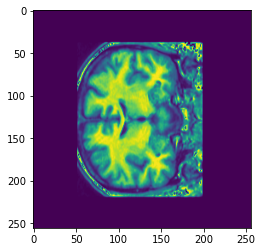

In [46]:
# @Citation: Hw4 Solution
def Final_Registration(moving_image, scale_factor, angle, deltas, method="linear"):
    rad = np.radians(angle)
    # Get new grid size
    max_sz = np.int(moving_image.shape[0]*(np.abs(np.cos(rad))+np.abs(np.sin(rad))))
    
    b = np.linspace(-max_sz//2, max_sz//2, max_sz)
    
    bb, aa = np.array(np.meshgrid(b,b))
    #R = 1 / scale_factor * np.array([[np.cos(rad), -np.sin(rad)],[np.sin(rad), np.cos(rad)]])
    R = np.array([[np.cos(rad), -np.sin(rad)],[np.sin(rad), np.cos(rad)]])
    
    #Transform the coordinates
    aa += deltas[0]
    bb += deltas[1]
    c_1 = R[0,0]*aa + R[0,1]*bb
    c_2 = R[1,0]*aa + R[1,1]*bb 
    
    c_1 *= 1/scale_factor[0]
    c_2 *= 1/scale_factor[1]

    b_orig = np.linspace(-128, 128, 256)
    # Construct the Interpolator, the default method is linear
    f = RegularGridInterpolator((b_orig, b_orig), moving_image, bounds_error = False, fill_value = 0, method = method)
    x_out = f(np.stack((c_1, c_2), axis=2))
    # Guarantee that the output has the same size as the input image
    return x_out[x_out.shape[0]//2-moving_image.shape[0]//2 : x_out.shape[0]//2+moving_image.shape[0]//2, 
                 x_out.shape[1]//2-moving_image.shape[1]//2 : x_out.shape[1]//2+moving_image.shape[1]//2]

test_example = training_imgs[0]
test_out = Final_Registration(test_example, [1.2, 1], 0, [0, 0])
plt.imshow(test_out)

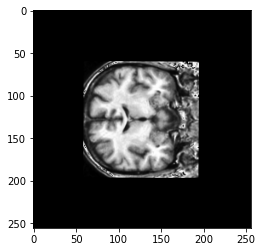

In [47]:
def Compute_Loss(parameters, fixed_image, moving_image):
    # get transformed image based on the given parameters
    transformed = Final_Registration(moving_image, [parameters[0], parameters[1]], parameters[2],
                                    [parameters[3], parameters[4]])
    # compute loss
    loss = np.sum(abs(fixed_image - transformed))
    #print(loss)
    return loss

def optimizator(fixed_image, moving_image):
    # Construct optimization model
    optimizationParameters = optimize.minimize(Compute_Loss, [1.0, 1.0, 0.0, 0.0, 0.0], method = 'Powell', 
                                      args = (fixed_image, moving_image), tol = 1e-9,  
                                      options={'maxiter': 2500, 'disp': False}).x
    # Get the transformed image based on the optimal parameters 
    transformed = Final_Registration(moving_image, [optimizationParameters[0], optimizationParameters[1]], optimizationParameters[2], 
                                     [optimizationParameters[3], optimizationParameters[4]])
    return transformed, optimizationParameters
transformed_img, parameters = optimizator(validation_imgs[0], training_imgs[0])
#print(parameters)
plt.imshow(transformed_img, cmap="gray")

In [66]:
training_more_imgs = np.concatenate((np.array(training_imgs), np.array(validation_imgs)))
training_more_labels = np.concatenate((np.array(training_labels), np.array(validation_labels)))

In [67]:
testing_parameters = np.zeros((len(testing_imgs), len(training_more_imgs), 5))
for i in range(len(testing_imgs)):
    for j in range(len(training_more_imgs)):
        # each training image (moving image) onto each validation image (fixed image)
        transformed_res, parameters = optimizator(testing_imgs[i], training_more_imgs[j])
        # store optimal parameters for each image pair into the list
        testing_parameters[i, j, :] = parameters

In [68]:
testing_labels = np.zeros((testing_parameters.shape[0], testing_parameters.shape[1], 
                        testing_imgs[0].shape[0], testing_imgs[0].shape[1]))
for i in range(testing_labels.shape[0]):
    for j in range(testing_labels.shape[1]):
    # resample the manual segmentations of each training subject onto the validation subject grids (use 
    # nearest neighbor interpolation) for testing image
        testing_labels[i, j, :, :] = Final_Registration(training_more_labels[j], [testing_parameters[i][j][0], testing_parameters[i][j][1]], 
                                                        testing_parameters[i][j][2], [testing_parameters[i][j][3],
                                                                                     testing_parameters[i][j][4]], method = 'nearest')

In [217]:
# compute summed squared distance in the neighborhood
def ComputeSSD(testing_img, training_img, x, y, r = 3):
    row1, row2, col1, col2 = x-r, x+r+1, y-r, y+r+1
    row1 = 0 if row1 < 0 else row1
    row2 = 256 if row2 > 256 else row2
    col1 = 0 if col1 < 0 else col1
    col2 = 256 if col2 > 256 else col2
    return math.exp(-np.sum(np.square((testing_img[row1:row2,col1:col2] - training_img[row1:row2, col1:col2])/255)))

# the most frequent training label (majority voting based label fusion)
#testing_pred[i, x, y] = np.argmax(np.bincount(testing_labels[i, :, x, y].astype(int)))
# segmentation quality estimations based on local appearance similarity (weighted label fusion strategy)
# Citation: Optimal Weights for Multi-Atlas Label Fusion Hongzhi Wang, Jung Wook Suh, John Pluta, Murat Altinay, and Paul Yushkevich
# iterate through the entire image to compute final pixel
testing_pred = np.zeros((testing_labels.shape[0], testing_imgs[0].shape[0], testing_imgs[0].shape[1]))
training_more_labels = training_more_labels.astype('int8')
for i in range(testing_labels.shape[0]):
    for x in range(256):
        for y in range(256):
            weights = np.zeros(testing_labels.shape[1])
            mappings = np.zeros(256)
            for j in range(testing_labels.shape[1]):
                weights[j] = ComputeSSD(testing_imgs[i], training_more_imgs[j], x, y)
            weights = weights / np.sum(weights)
            for j in range(training_more_labels.shape[0]):
                mappings[training_more_labels[j, x, y]] += weights[j]
            testing_pred[i, x, y] = np.argmax(mappings)

In [218]:
#for i in range(testing_pred.shape[0]):
    #testing_pred[i] = np.around(testing_pred[i]).astype('int8')testing_pred.astype('int8')
testing_pred = testing_pred.astype('int8')

In [219]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [220]:
labels = []
predication = []
def writeToCSV(image_id, image):
    global labels, predication
    labels.append(str(image_id) + "-left-wm")
    predication.append(rle_encode(image == 2))
    labels.append(str(image_id) + "-left-cortex")
    predication.append(rle_encode(image == 3))
    labels.append(str(image_id) + "-right-wm")
    predication.append(rle_encode(image == 41))
    labels.append(str(image_id) + "-right-cortex")
    predication.append(rle_encode(image == 42))

Testing_id = [8, 9, 10, 11, 12, 13, 14, 16, 17]

for i in range(testing_pred.shape[0]):
    writeToCSV(Testing_id[i], testing_pred[i])
### ids: list containing the 36 IDs as described above  ###
### data: list containing the 36 binary segmentation masks in RLE format ### 
df = pd.DataFrame({"Id": labels, "Predicted": predication})
df.to_csv('submission8.csv', index = False)

In [54]:
np.save("testing_5_parameters.npy", testing_parameters)